# Imports

In [36]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Set Paths

In [37]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

# Load Data

In [38]:
# Load the ABF file
abf = pyabf.ABF(f'{project_path}PTX6L2 ACCOM.abf')



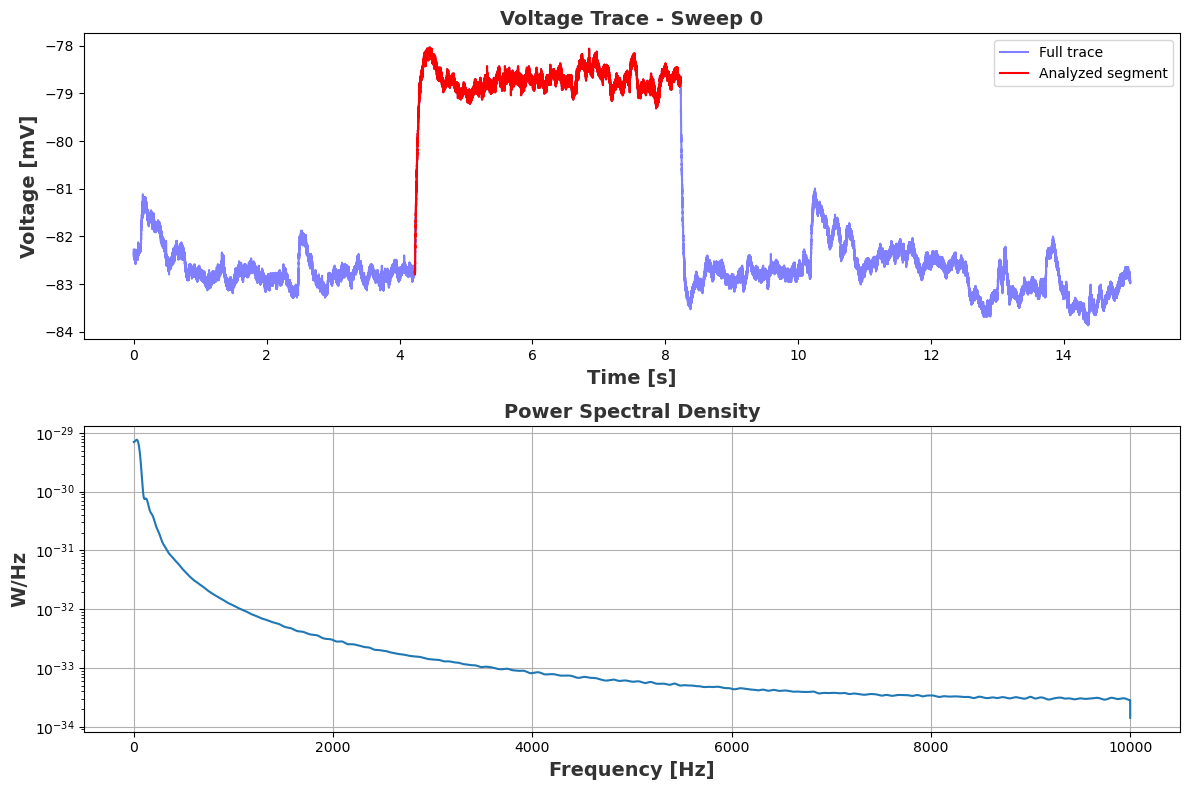

Analysis for sweep 0 time segment: 4.23 to 8.23 seconds
Total power for sweep 0 (excluding <0.1 Hz): 2.486719e-03 yoctoWatt


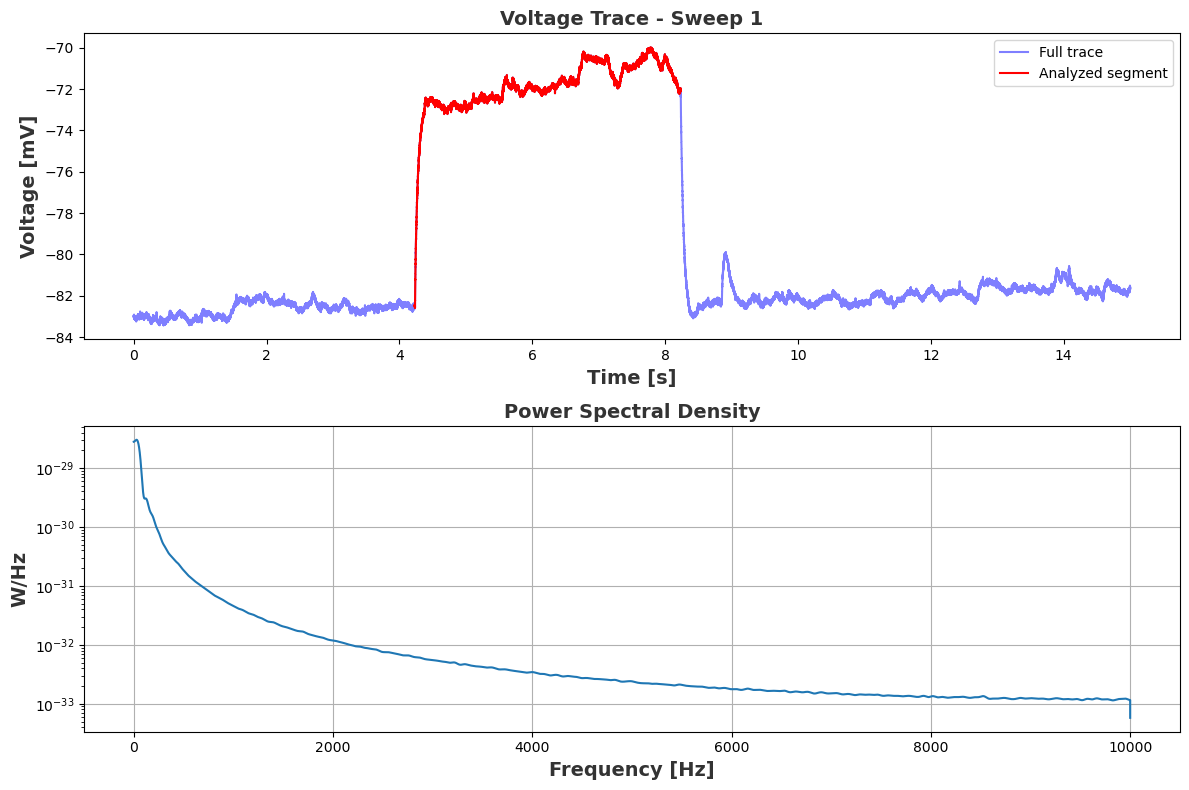

Analysis for sweep 1 time segment: 4.23 to 8.23 seconds
Total power for sweep 1 (excluding <0.1 Hz): 9.844166e-03 yoctoWatt


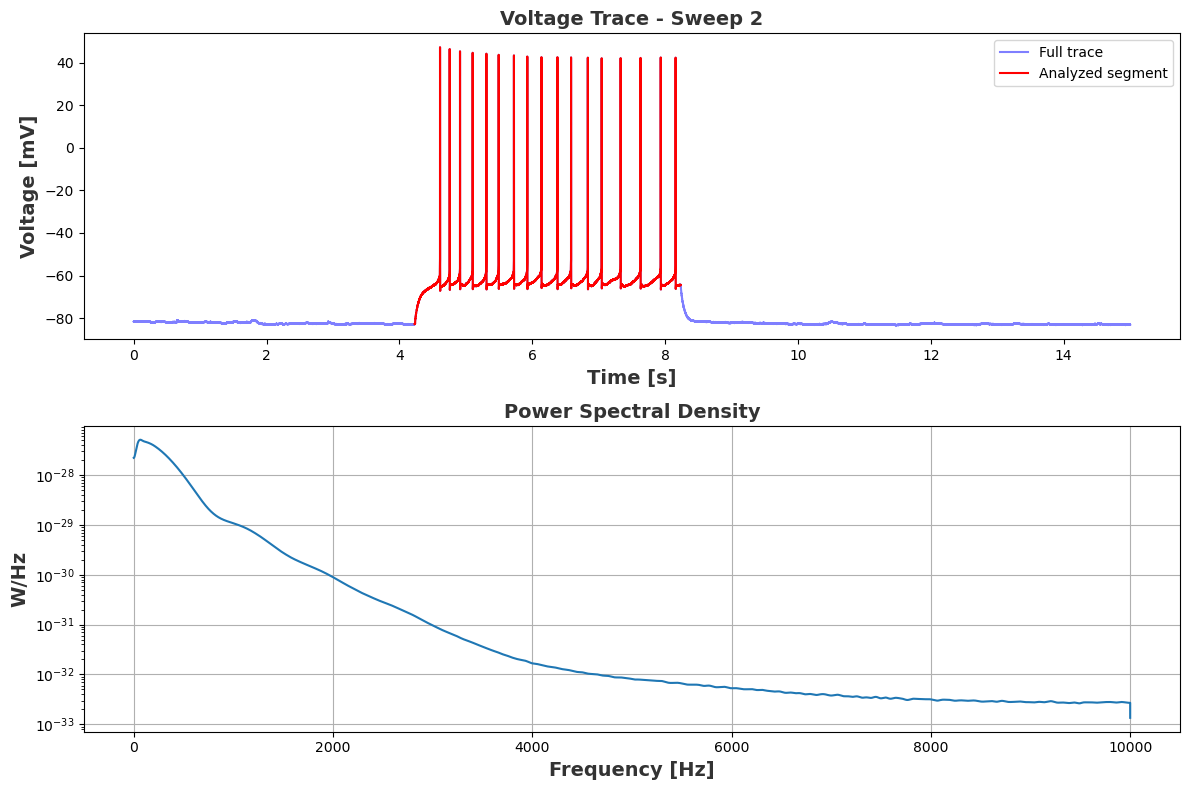

Analysis for sweep 2 time segment: 4.23 to 8.23 seconds
Total power for sweep 2 (excluding <0.1 Hz): 6.980840e-01 yoctoWatt


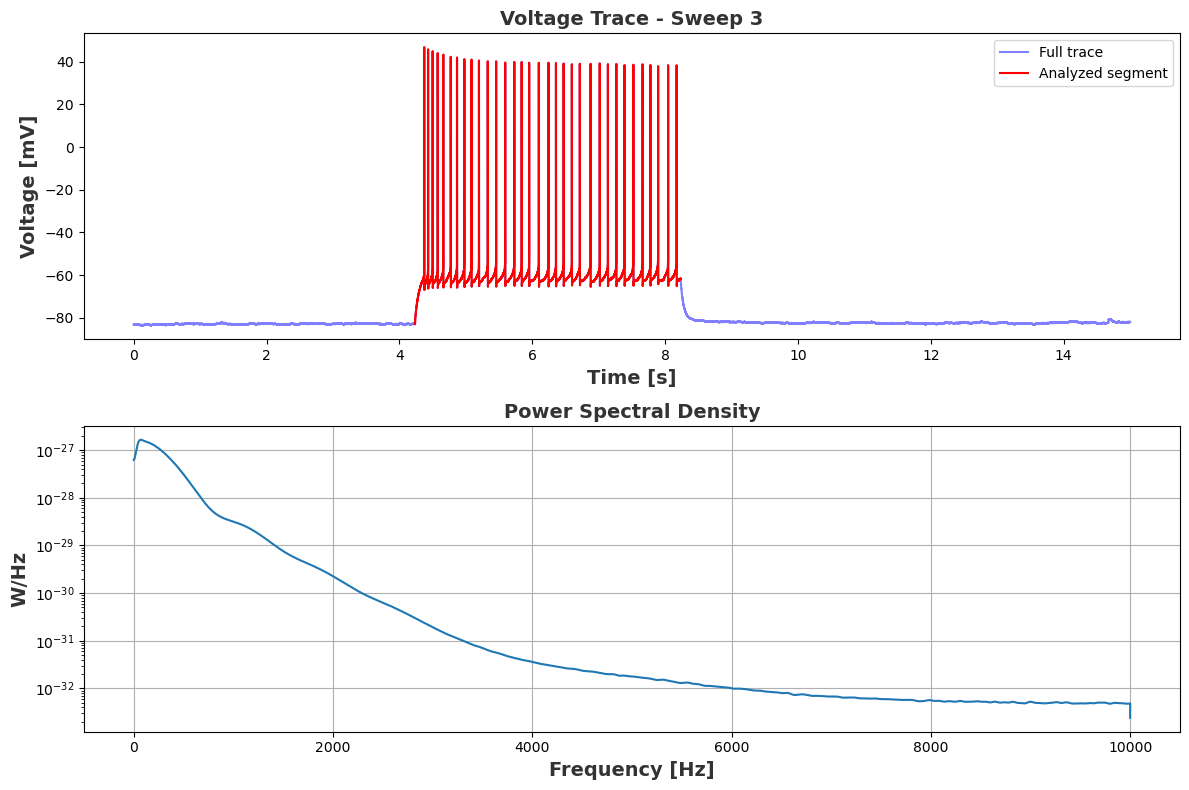

Analysis for sweep 3 time segment: 4.23 to 8.23 seconds
Total power for sweep 3 (excluding <0.1 Hz): 2.240920e+00 yoctoWatt


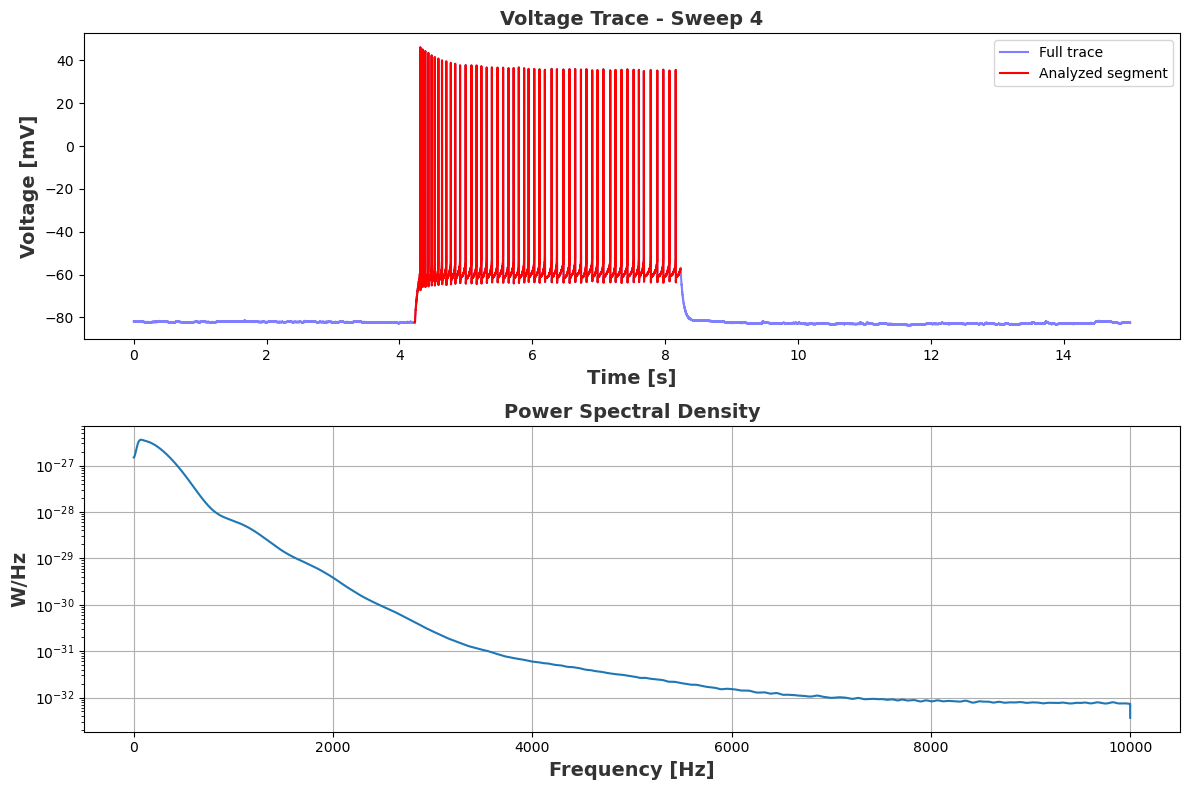

Analysis for sweep 4 time segment: 4.23 to 8.23 seconds
Total power for sweep 4 (excluding <0.1 Hz): 4.961172e+00 yoctoWatt


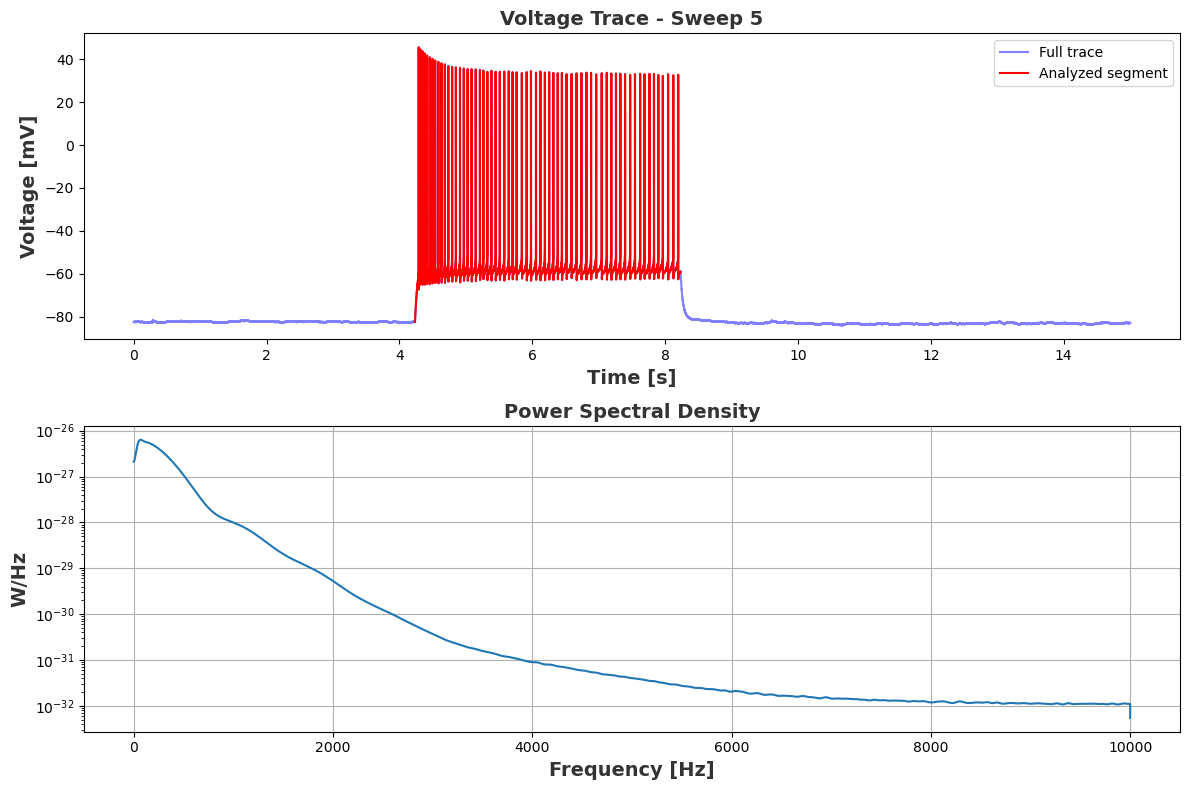

Analysis for sweep 5 time segment: 4.23 to 8.23 seconds
Total power for sweep 5 (excluding <0.1 Hz): 8.198768e+00 yoctoWatt


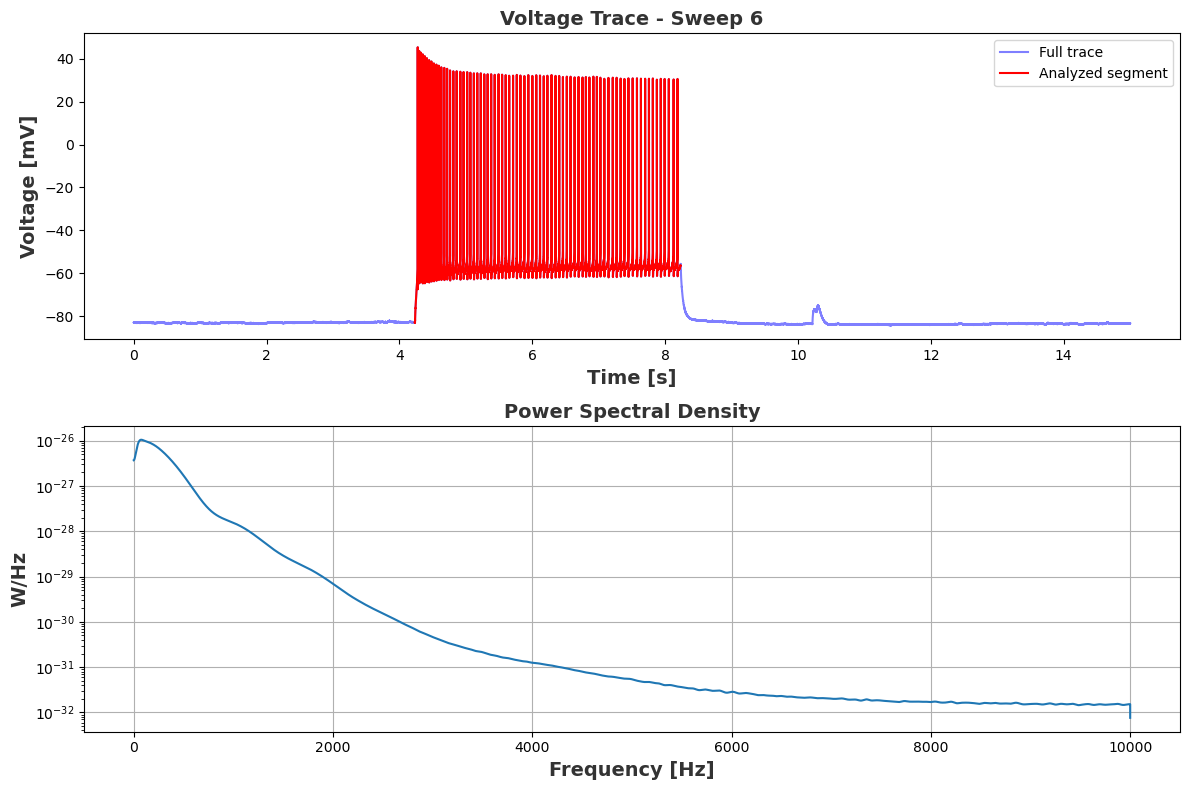

Analysis for sweep 6 time segment: 4.23 to 8.23 seconds
Total power for sweep 6 (excluding <0.1 Hz): 1.353141e+01 yoctoWatt


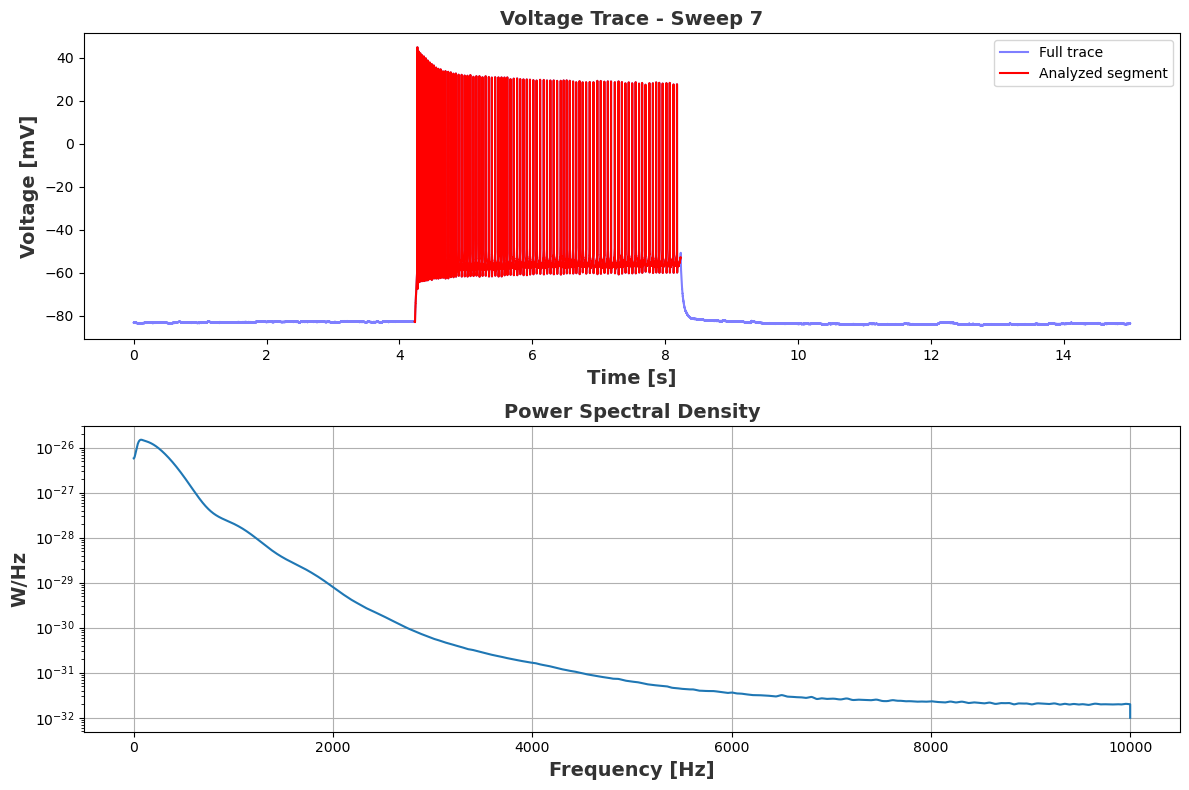

Analysis for sweep 7 time segment: 4.23 to 8.23 seconds
Total power for sweep 7 (excluding <0.1 Hz): 1.922558e+01 yoctoWatt

Sum of total power across all sweeps: 4.886827e+01 yoctoWatt

Average of total power in each sweep: 6.108533e+00 yoctoWatt


In [39]:
# Set the desired sweep and channel
sweep_numbers = [0, 1, 2, 3, 4, 5, 6, 7]
total_power_sum = 0  # Initialize the sum of total power
sweep_powers = []  # List to store the total power of each sweep

LJP = 13  # Liquid Junction Potential in mV

for sweep in sweep_numbers:
    abf.setSweep(sweep, channel=0)
    # Define the time segment for analysis (in seconds)
    start_time = 4.23  # Start time in seconds
    end_time = 8.23    # End time in seconds

    # Extract voltage (sweepY) and time (sweepX)
    voltage = abf.sweepY - LJP # Voltage in mV
    times = abf.sweepX    # Time in seconds

    # Extract current command waveform (sweepC)
    current_command = abf.sweepC  # Current in pA

    # Find indices corresponding to the desired time segment
    start_index = np.argmin(np.abs(times - start_time))
    end_index = np.argmin(np.abs(times - end_time))

    # Extract the specific portion of the data for analysis
    segment_times = times[start_index:end_index]
    segment_voltage = voltage[start_index:end_index]
    segment_current = current_command[start_index:end_index]

    # Convert current from pA to A for power calculation
    segment_current_A = segment_current * 1e-12

    # Convert voltage from mV to V for power calculation
    segment_voltage_V = segment_voltage * 1e-3

    # Recalculate instantaneous power: P = V * I
    instantaneous_power = segment_voltage_V * segment_current_A
    
    # Calculate the Power Spectral Density (PSD) of the instantaneous power using Welch's method with zero padding
    fs = abf.dataRate  # Sampling frequency from ABF file
    segment_length_ms = 20  # Optimal segment length in milliseconds
    nperseg = int(fs * segment_length_ms / 1000)
    noverlap = nperseg // 2  # 50% overlap

    # Ensure nperseg is an even number for efficient FFT
    nperseg = nperseg + (nperseg % 2)
    #Zero Padding
    nfft = 320000  # Increase FFT size such that frequency resolution is 0.05Hz

    # Apply Welch's method with zero padding
    f, Pxx = signal.welch(instantaneous_power, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, nfft=nfft, scaling='density')

    # Calculate total power excluding frequencies below 0.1 Hz
    freq_mask = (f >= 0.1) & (f <= 10000)
    average_power_above_0_1Hz = np.trapz(Pxx[freq_mask], f[freq_mask])  # Integrate PSD above 0.1 Hz

    # Calculate the duration of the sweep
    sweep_duration = end_time - start_time

    # Calculate total power by multiplying average power by the duration
    total_power_above_0_1Hz = average_power_above_0_1Hz * sweep_duration * 1e24  # Convert to yoctoWatt

    # Add the total power for this sweep to the sum
    total_power_sum += total_power_above_0_1Hz
    
    # Append the total power for this sweep to the list
    sweep_powers.append(total_power_above_0_1Hz)

    # Plot the PSD and exclude all frequencies below 0.1 Hz
    plt.figure(figsize=(12, 8))

    # Plot 1: Original voltage trace with highlighted segment
    plt.subplot(2, 1, 1)
    plt.plot(times, voltage, 'b', alpha=0.5, label='Full trace')
    plt.plot(segment_times, segment_voltage, 'r', label='Analyzed segment')
    plt.xlabel('Time [s]', fontsize=14, weight='bold', color='0.2')
    plt.ylabel('Voltage [mV]', fontsize=14, weight='bold', color='0.2')
    plt.title(f'Voltage Trace - Sweep {sweep}', fontsize=14, weight='bold', color='0.2')
    plt.legend()

    # Plot 2: PSD of instantaneous power
    plt.subplot(2, 1, 2)
    plt.semilogy(f[freq_mask], Pxx[freq_mask])  # Focus on frequencies above 0.1 Hz
    plt.xlabel('Frequency [Hz]', fontsize=14, weight='bold', color='0.2')
    plt.ylabel('W/Hz', fontsize=14, weight='bold', color='0.2')
    plt.title(f'Power Spectral Density', fontsize=14, weight='bold', color='0.2')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Analysis for sweep {sweep} time segment: {start_time} to {end_time} seconds")
    print(f"Total power for sweep {sweep} (excluding <0.1 Hz): {total_power_above_0_1Hz:.6e} yoctoWatt")

# Print the sum of total power across all sweeps
print(f"\nSum of total power across all sweeps: {total_power_sum:.6e} yoctoWatt")

# Calculate and print the average of total power in each sweep
average_power_per_sweep = np.mean(sweep_powers)
print(f"\nAverage of total power in each sweep: {average_power_per_sweep:.6e} yoctoWatt")
